In [2]:
from __future__ import annotations
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
MAIN_DIR = '/Users/alex/Desktop/CS/Internships/DBF/Alex_DBF/python_tools/data/year2/01-28-2025'
OUTPUT_DIR = MAIN_DIR + '/output'

In [4]:
MIN_THROTTLE = 1000
MAX_THROTTLE = 2011

In [5]:
blackbox_dfs: dict[str, pd.DataFrame] = {}

for file in os.listdir(MAIN_DIR):
    if file.endswith('.csv'):
        blackbox_dfs[file.removesuffix('.csv')] = pd.read_csv(MAIN_DIR + '/' + file, comment='#')

blackbox_dfs.keys()

dict_keys(['AT5520_220KV_18X10CFRP_RUN1', 'AT5520_220KV_16X12_RUN1', 'AT5520_220KV_3X15X14R_RUN1'])

In [6]:
torque_dfs: dict[str, pd.DataFrame] = {}

for file in os.listdir(MAIN_DIR):
    if file.endswith('.txt'):
        torque_dfs[file.removesuffix('.txt')] = pd.read_csv(MAIN_DIR + '/' + file, header=None)
        torque_dfs[file.removesuffix('.txt')].columns = ['loopIteration', 'thrust', 'torque', 'ignore_1', 'ignore2']

torque_dfs.keys()

dict_keys(['AT5520_220KV_18X10CFRP_RUN1', 'AT5520_220KV_3X15X14R_RUN1', 'AT5520_220KV_16X12_RUN1'])

In [7]:
# find non common df names
torque_only_dfs = set(torque_dfs.keys()).difference(set(blackbox_dfs.keys()))
print('Torque but not blackbox:', torque_only_dfs)

blackbox_only_dfs = set(blackbox_dfs.keys()).difference(set(torque_dfs.keys()))
print('Blackbox but not torque:', blackbox_only_dfs)

Torque but not blackbox: set()
Blackbox but not torque: set()


In [8]:
# find common df names
common_dfs = set(blackbox_dfs.keys()).intersection(set(torque_dfs.keys()))
print(common_dfs)

{'AT5520_220KV_16X12_RUN1', 'AT5520_220KV_3X15X14R_RUN1', 'AT5520_220KV_18X10CFRP_RUN1'}


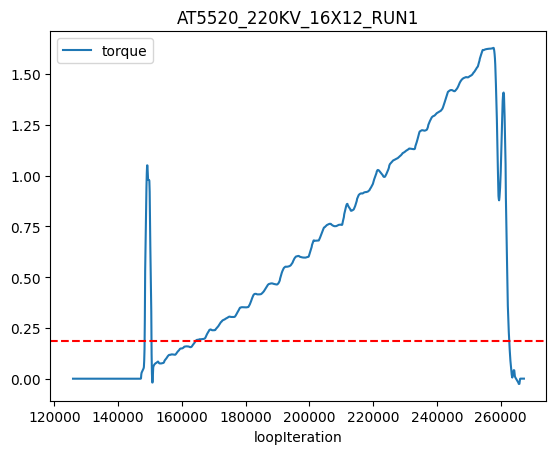

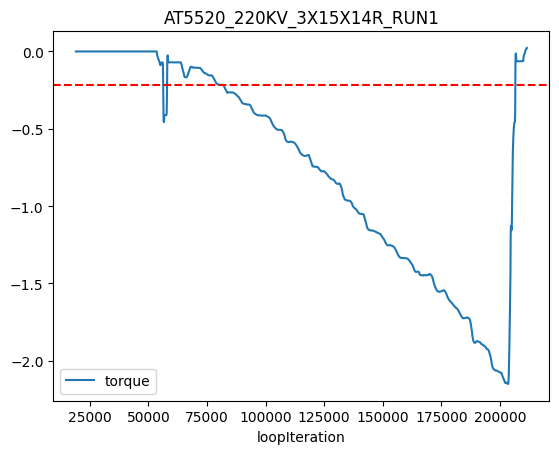

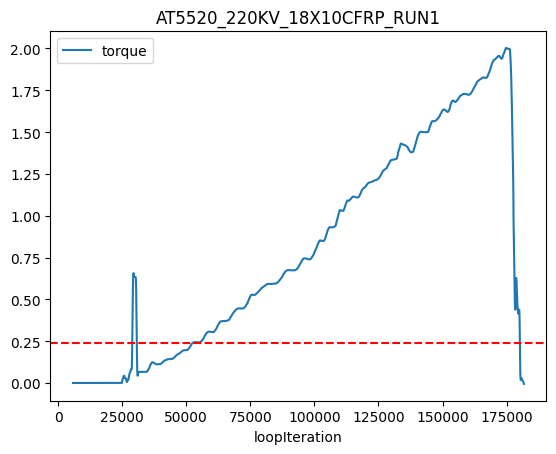

In [25]:
for key in common_dfs:
    ax = torque_dfs[key].plot(x='loopIteration', y='torque', title=key)
    ax.axhline(torque_dfs[key]['torque'].mean() * 0.3, color='r', linestyle='--')

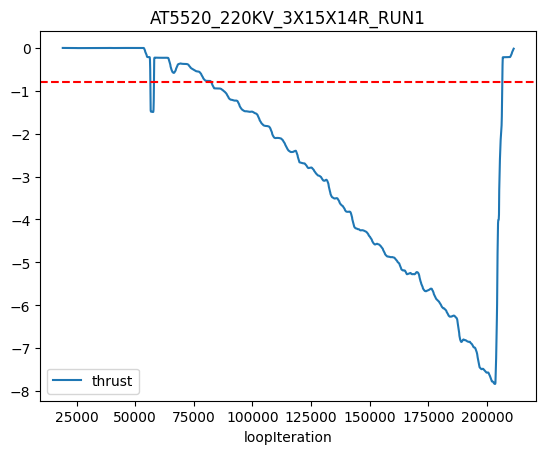

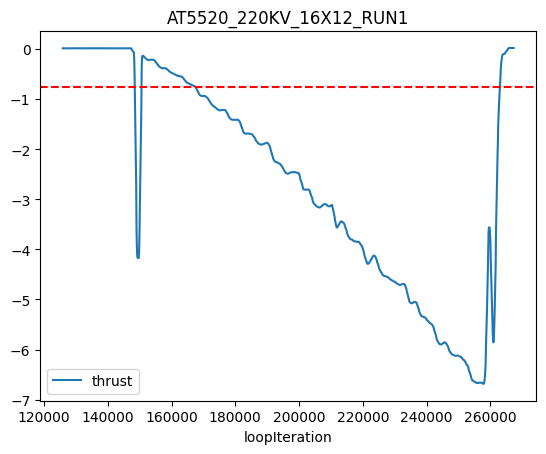

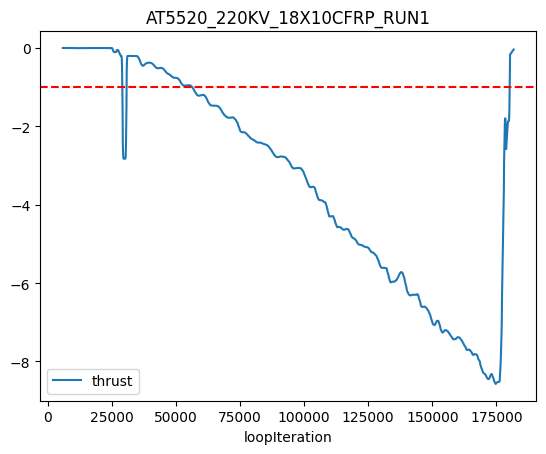

In [38]:
for key in common_dfs:
    ax = torque_dfs[key].plot(x='loopIteration', y='thrust', title=key)
    ax.axhline(torque_dfs[key]['thrust'].mean() * 0.3, color='r', linestyle='--')

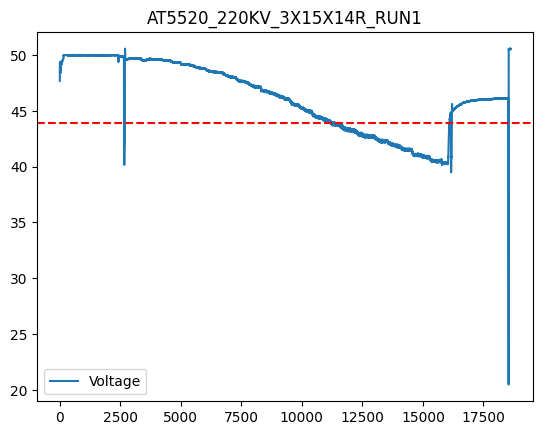

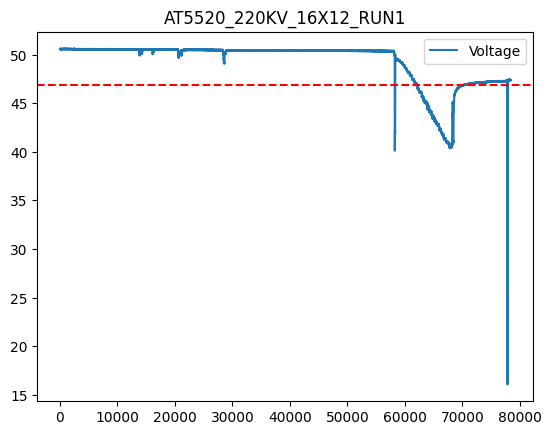

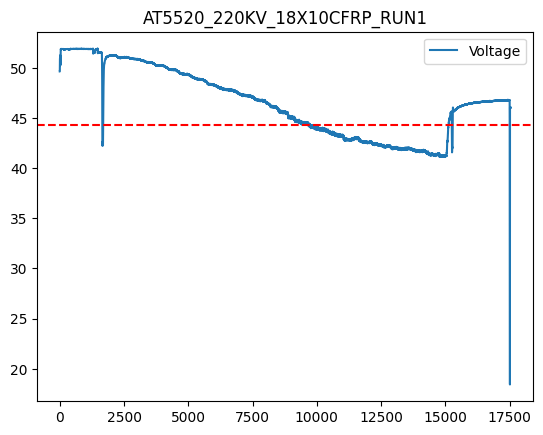

In [33]:
for key in common_dfs:
    ax = blackbox_dfs[key].plot(y='Voltage', title=key)
    ax.axhline(blackbox_dfs[key]['Voltage'].mean() * 0.95, color='r', linestyle='--')

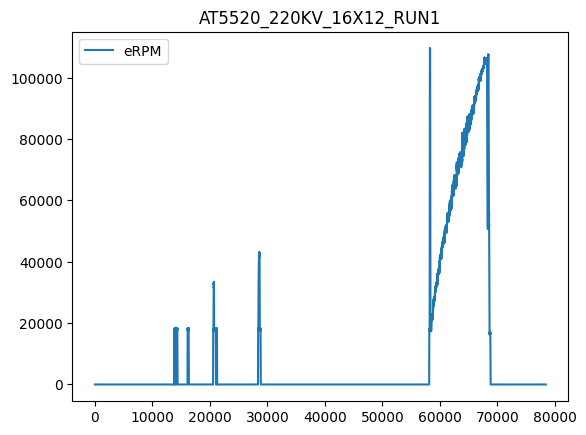

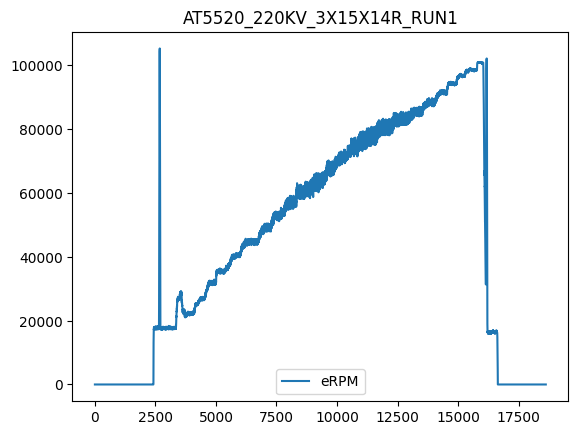

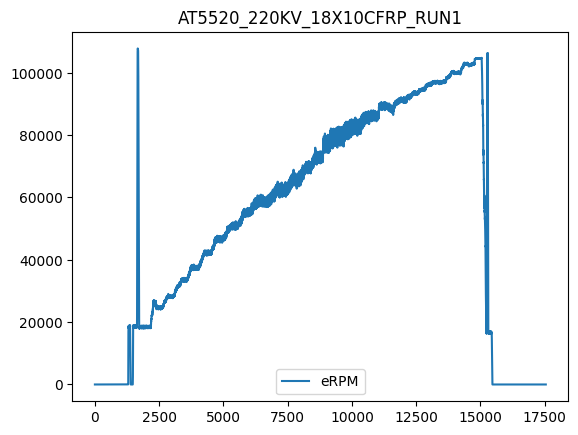

In [10]:
for key in common_dfs:
    ax = blackbox_dfs[key].plot(y='eRPM', title=key)

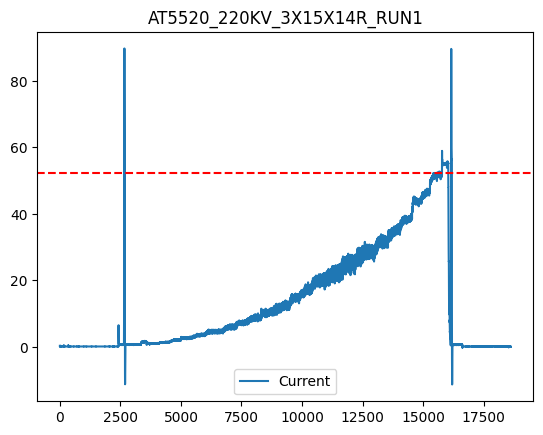

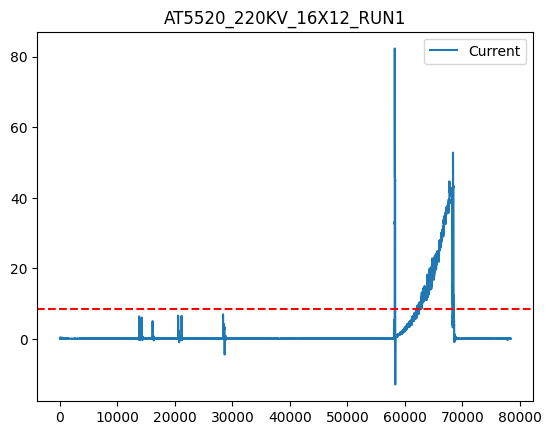

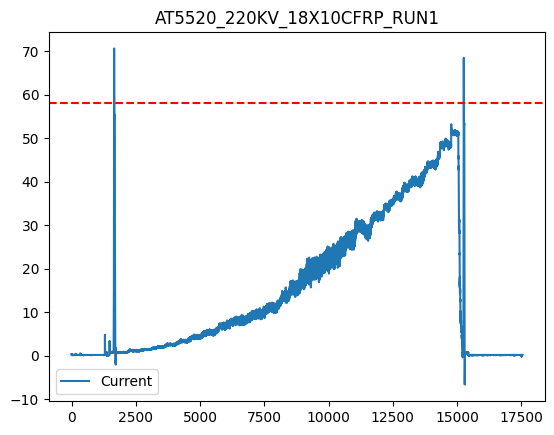

In [41]:
for key in common_dfs:
    ax = blackbox_dfs[key].plot(y='Current', title=key)
    ax.axhline(blackbox_dfs[key]['Current'].mean() * 4, color='r', linestyle='--')

AT5520_220KV_16X12_RUN1
AT5520_220KV_3X15X14R_RUN1
AT5520_220KV_18X10CFRP_RUN1


/var/folders/gz/pp4ldsnj0tjbngm2gygkp8qc0000gn/T/ipykernel_95247/1885543073.py:41: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_bucketed_by_current = df.groupby(pd.cut(df['Current'], bins=20)).mean()
/var/folders/gz/pp4ldsnj0tjbngm2gygkp8qc0000gn/T/ipykernel_95247/1885543073.py:45: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_bucketed_by_voltage = df.groupby(pd.cut(df['Voltage'], bins=20)).mean()
/var/folders/gz/pp4ldsnj0tjbngm2gygkp8qc0000gn/T/ipykernel_95247/1885543073.py:49: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only 

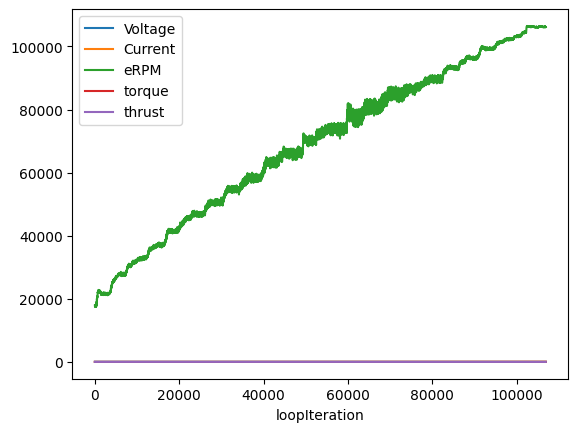

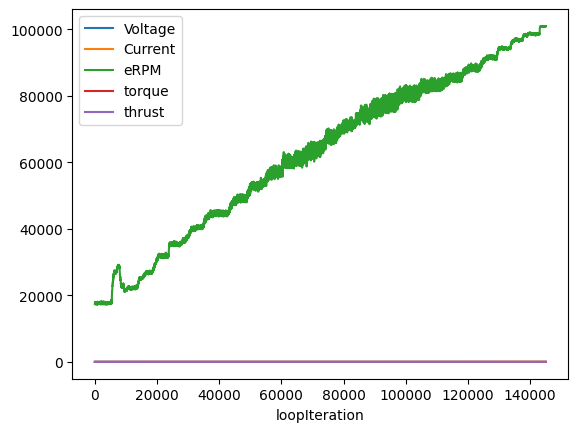

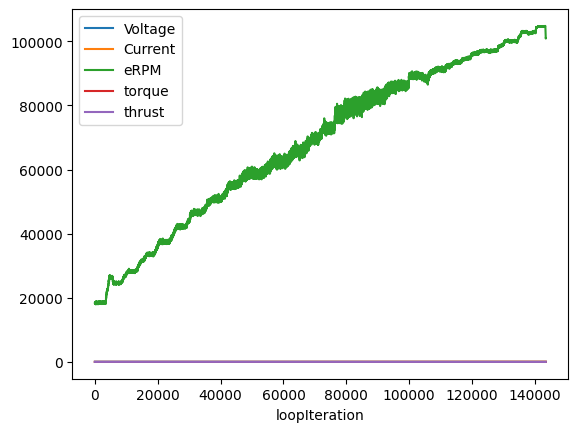

In [ ]:
BLACKBOX_COLS = ['Voltage', 'Current', 'eRPM']
TORQUE_COLS = ['torque', 'thrust']
METADATA = ['motor', 'kv', 'prop', 'run']

for name in list(common_dfs):
    print(name)

    metadata = dict(zip(METADATA, name.split("_")))

    df = blackbox_dfs[name][BLACKBOX_COLS].copy()
    first_peak = df['Current'].idxmax() #df['Current'].gt(df['Current'].mean() * 4).idxmax()
    last_peak = df['Current'].iloc[int(first_peak)+2000:].idxmax()
    df = df.iloc[first_peak+200:last_peak-200]
    df.reset_index(drop=True, inplace=True)

    df_torque = torque_dfs[name][['loopIteration'] + TORQUE_COLS].copy()
    df_torque['loopIteration'] = df_torque['loopIteration'].astype(np.int64)
    peak_thrust_it = df_torque['loopIteration'][df_torque['thrust'].lt(df_torque['thrust'].mean() * 0.3).idxmax()]
    df_torque = df_torque[df_torque['loopIteration'].ge(peak_thrust_it)]
    min_thrust_it = df_torque['loopIteration'][df_torque['thrust'].idxmin()]
    df_torque = df_torque[df_torque['loopIteration'].le(min_thrust_it)]
    max_thrust_it = df_torque['loopIteration'][df_torque['thrust'].idxmax()]
    df_torque = df_torque[df_torque['loopIteration'].ge(max_thrust_it)]
    df_torque['loopIteration'] -= df_torque['loopIteration'].min()
    df_torque_len = df_torque['loopIteration'].max() - df_torque['loopIteration'].min()

    len_ratio = df_torque_len / len(df)

    df['loopIteration'] = np.int64(df.index * len_ratio)
    
    df = pd.merge_asof(df, df_torque, left_on='loopIteration', right_on='loopIteration', direction='nearest')

    for col in METADATA:
        df[col] = metadata[col]

    df = df[['loopIteration'] + BLACKBOX_COLS + TORQUE_COLS + METADATA]
    df.to_csv(OUTPUT_DIR + "/" + name + ".csv", index=False)
    df.plot(x='loopIteration')
    plt.savefig(OUTPUT_DIR + "/" + name + ".png")

    df_bucketed_by_current = df.groupby(pd.cut(df['Current'], bins=20)).mean()
    df_bucketed_by_current.drop(columns=['loopIteration'], inplace=True)
    df_bucketed_by_current.to_csv(OUTPUT_DIR + "/" + name + "_bucketed_by_current.csv")
    
    df_bucketed_by_voltage = df.groupby(pd.cut(df['Voltage'], bins=20)).mean()
    df_bucketed_by_voltage.drop(columns=['loopIteration'], inplace=True)
    df_bucketed_by_voltage.to_csv(OUTPUT_DIR + "/" + name + "_bucketed_by_voltage.csv")

    df_bucketed_by_torque = df.groupby(pd.cut(df['torque'], bins=20)).mean()
    df_bucketed_by_torque.drop(columns=['loopIteration'], inplace=True)
    df_bucketed_by_torque.to_csv(OUTPUT_DIR + "/" + name + "_bucketed_by_torque.csv")

    df_bucketed_by_thrust = df.groupby(pd.cut(df['thrust'], bins=20)).mean()
    df_bucketed_by_thrust.drop(columns=['loopIteration'], inplace=True)
    df_bucketed_by_thrust.to_csv(OUTPUT_DIR + "/" + name + "_bucketed_by_thrust.csv")

    df_bucketed_by_time = df.groupby(pd.cut(df['loopIteration'], bins=20)).mean()
    df_bucketed_by_time.drop(columns=['loopIteration'], inplace=True)
    df_bucketed_by_time.to_csv(OUTPUT_DIR + "/" + name + "_bucketed_by_time.csv")